In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [12]:
from skimage.io import imread

images, lesions = [], []
for root, dirs, files in os.walk('./kaggle/input/ph2dataset/PH2Dataset/PH2_Dataset/'):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))
len(images), len(lesions)

(200, 200)

In [13]:
from skimage.transform import resize

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


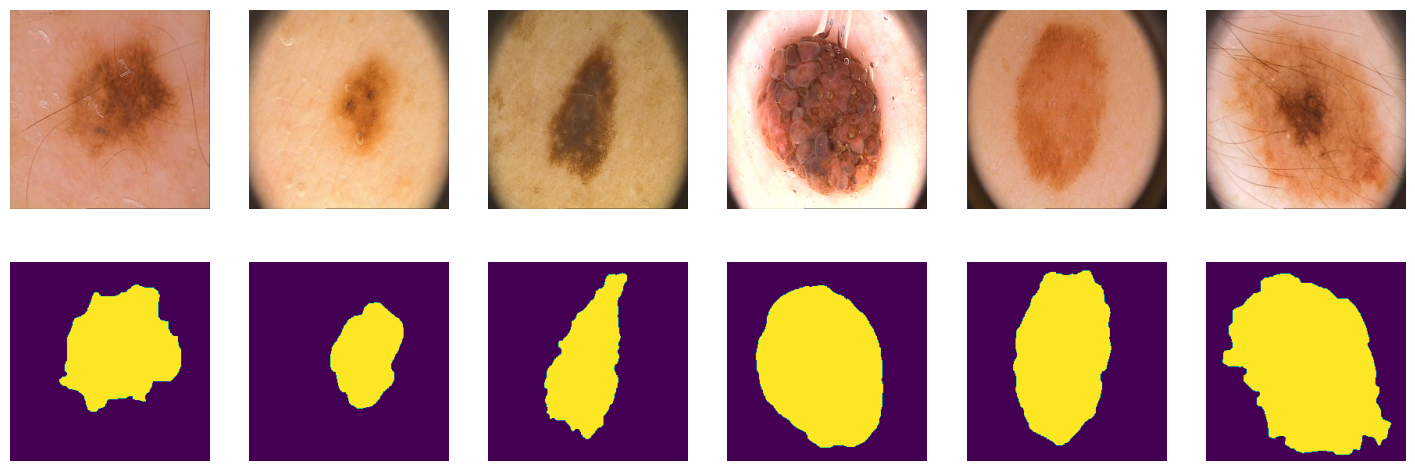

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
for i in range(1, 7):
    for pos, pic in zip((i, i+6), (X[i], Y[i])):
        plt.subplot(2, 6, pos)
        plt.axis("off")
        plt.imshow(pic)

plt.show();

In [15]:
idx = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(idx, [100, 150])
print(len(tr), len(val), len(ts))

100 50 50


In [16]:
from torch.utils.data import DataLoader

BATCH_SIZE = 25

data_tr  = DataLoader(list(zip(np.rollaxis(X[tr],  3, 1), Y[tr, np.newaxis])),
                      batch_size=BATCH_SIZE, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=BATCH_SIZE, shuffle=True)
data_ts  = DataLoader(list(zip(np.rollaxis(X[ts],  3, 1), Y[ts, np.newaxis])),
                      batch_size=BATCH_SIZE, shuffle=True)
print('successful')

successful


In [17]:
import torch

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cpu


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)

In [19]:
from torchvision import models
vgg = models.vgg16()
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [20]:
# Поскольку сеть из многих повторяющихся блоков, сделаем такой блок классом

class OneUnit(nn.Module):
    """
    Блок Conv2D + BatchNorm + Relu
    param ker_size: размер стороны квадратного ядра свёртки, int
    param stride_size: отступ страйда, int
    param pad_size: отступ паддинга, int
    """
    def __init__(self, in_channels, out_channels, ker_size, stride_size, pad_size):
        super(OneUnit, self).__init__()
        self.unit = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=ker_size,
                      padding=pad_size, stride=stride_size),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.unit(x)

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            OneUnit(3,  64, 3, 1, 1),
            OneUnit(64, 64, 3, 1, 1)
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            OneUnit(64,  128, 3, 1, 1),
            OneUnit(128, 128, 3, 1, 1),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            OneUnit(128, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1)
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            OneUnit(256, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1)
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottle_neck = nn.Sequential(
            OneUnit(512, 512, 1, 1, 0),
            OneUnit(512, 512, 1, 1, 0),
            OneUnit(512, 512, 1, 1, 0),
            OneUnit(512, 512, 1, 1, 0)
        )

        # decoder (upsampling)

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 512, 3, 1, 1),
            OneUnit(512, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 256, 3, 1, 1),
            OneUnit(256, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            OneUnit(128, 128, 3, 1, 1),
            OneUnit(128,  64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            OneUnit(64, 64, 3, 1, 1),

            # последний блок отличается от паттерна
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # в последнем слое активация не нужна
        )

    def forward(self, inp):
        # encoder
        enc0, idx0 = self.pool0(self.enc_conv0(inp))
        enc1, idx1 = self.pool1(self.enc_conv1(enc0))
        enc2, idx2 = self.pool2(self.enc_conv2(enc1))
        enc3, idx3 = self.pool3(self.enc_conv3(enc2))

        # bottleneck
        neck = self.bottle_neck(enc3)

        # decoder
        dec3 = self.dec_conv3(self.upsample3(neck, idx3))
        dec2 = self.dec_conv2(self.upsample2(dec3, idx2))
        dec1 = self.dec_conv1(self.upsample1(dec2, idx1))
        dec0 = self.dec_conv0(self.upsample0(dec1, idx0))

        # no activation
        return dec0

print('NAME:\tSegNet\nPARAMS:\t', sum(len(p) for p in SegNet().parameters() if p.requires_grad))

NAME:	SegNet
PARAMS:	 27652


In [21]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, treshold=0.5, SMOOTH=1e-8):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()             # BATCH x 1 x H x W => BATCH x H x W
    labels  = labels.squeeze(1).byte()

    inter = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both are 0

    iou = (inter + SMOOTH) / (union + SMOOTH)                       # We avoid 0/0
    # [0, 1] => [-1, 1]
    return torch.clamp(20 * (iou - treshold), 0, 10).ceil() / 10

print('successful')

successful


In [22]:
def bce_loss_test(y_real, y_pred):
    return nn.BCEWithLogitsLoss()(y_real, y_pred)

def bce_loss(y_pred, y_real):
    loss = (1 - y_real) * y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.mean()

# протестируем функцию, сравнив с той, что из коробки
y_r = torch.Tensor(np.random.sample(100).reshape(-1, 1))
y_p = 0.5 * y_r

bce_loss_test(y_r, y_p), bce_loss(y_r, y_p)       # совпадают

(tensor(0.8214), tensor(0.8214))

In [23]:
def score_model(model, metric, data, treshold=0.5):
    model.eval()               # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = torch.sigmoid(model(X_batch.to(device)))
            Y_pred = torch.where(Y_pred > treshold, 1, 0)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores / len(data)

print('successful')

successful


In [24]:
from IPython.display import clear_output
import gc

def train(model, opt, loss_fn, epochs, data_tr, data_val, metric=iou_pytorch):
    if is_cuda:
        torch.cuda.empty_cache()
    gc.collect()
    losses = {'train': [], 'valid': []}
    scores = []
    for epoch in range(1, epochs+1):
        tic = time()
        print(f'* Epoch:\t{epoch}/{epochs}')
        avg_loss = 0
        model.train()  # train mode

        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss   = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()                   # backward-pass
            opt.step()                        # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(f'train_loss:\t{avg_loss}')
        losses['train'].append(avg_loss.item())

        # show intermediate results
        model.eval()
        avg_loss = 0
        for X_val, Y_val in data_val:   # testing mode
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).detach().cpu()   # detach and put into cpu
                loss = loss_fn(Y_hat, Y_val)                     # forward-pass
                avg_loss += loss / len(data_val)
        losses['valid'].append(avg_loss.item())

        scores.append(score_model(model, metric, data_val))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'{epoch} / {epochs} - val_loss: {avg_loss:.5f}, val_metr: {scores[-1]:.5f}')
        plt.show()

    return [losses, scores]

print('successful')

successful


In [25]:
from IPython.display import clear_output
import gc

def train(model, opt, loss_fn, epochs, data_tr, data_val, metric=iou_pytorch):
    if is_cuda:
        torch.cuda.empty_cache()
    gc.collect()
    losses = {'train': [], 'valid': []}
    scores = []
    for epoch in range(1, epochs+1):
        tic = time()
        print(f'* Epoch:\t{epoch}/{epochs}')
        avg_loss = 0
        model.train()  # train mode

        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss   = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()                   # backward-pass
            opt.step()                        # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(f'train_loss:\t{avg_loss}')
        losses['train'].append(avg_loss.item())

        # show intermediate results
        model.eval()
        avg_loss = 0
        for X_val, Y_val in data_val:   # testing mode
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).detach().cpu()   # detach and put into cpu
                loss = loss_fn(Y_hat, Y_val)                     # forward-pass
                avg_loss += loss / len(data_val)
        losses['valid'].append(avg_loss.item())

        scores.append(score_model(model, metric, data_val))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'{epoch} / {epochs} - val_loss: {avg_loss:.5f}, val_metr: {scores[-1]:.5f}')
        plt.show()

    return [losses, scores]

print('successful')

successful


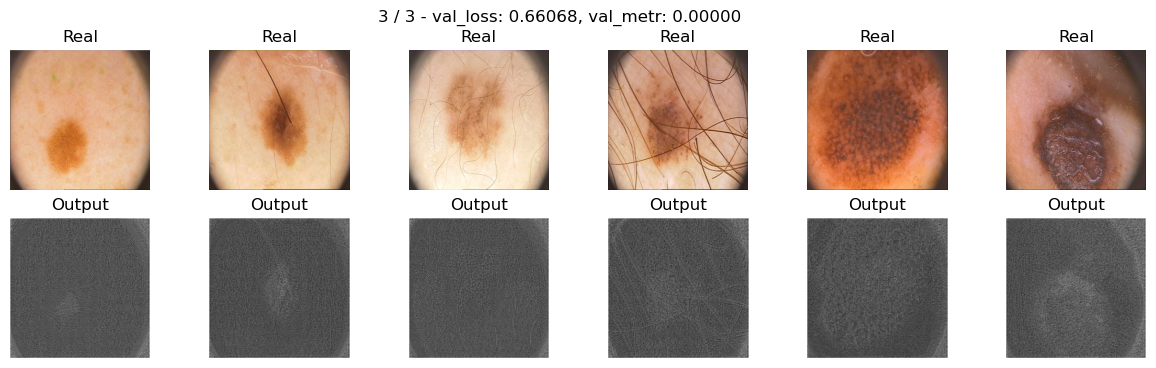

VALID:	 0.0 
TEST:	 0.0


In [29]:
import torch.optim as optim

MAX_EPOCHS = 3 # 25

model_bce = SegNet().to(device)
opt = optim.Adam(model_bce.parameters())
res_bce, acc_bce = train(model_bce, opt, bce_loss, MAX_EPOCHS, data_tr, data_val)

print('VALID:\t', score_model(model_bce, iou_pytorch, data_val),
      '\nTEST:\t', score_model(model_bce, iou_pytorch, data_ts))

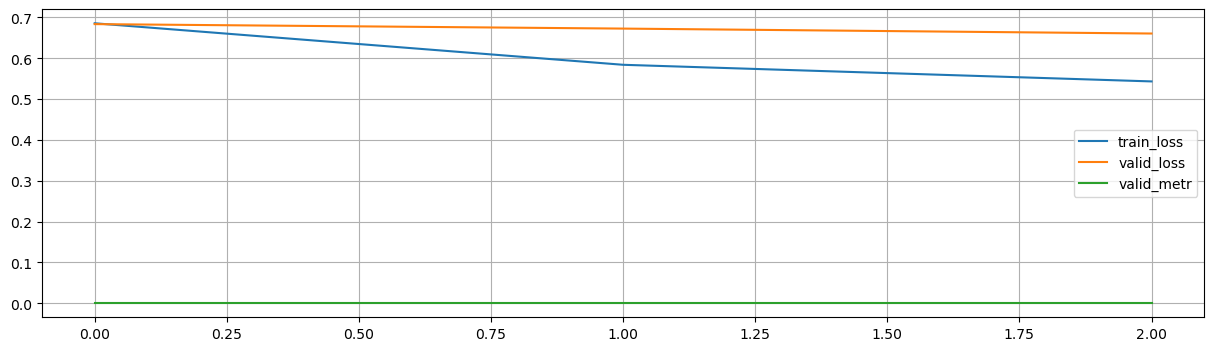

In [30]:
res, acc = res_bce, acc_bce
ep = range(len(res['train']))
plt.plot(ep, res['train'], label='train_loss')
plt.plot(ep, res['valid'], label='valid_loss')
plt.plot(ep, acc, label='valid_metr')
plt.grid()
plt.legend();